In [55]:
import keras
import cv2
import os
import numpy as np
import pickle
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, UpSampling2D, Input, merge
from keras.layers import Convolution2D, MaxPooling2D
from keras.models import Model
from keras import backend as K
from keras.utils import plot_model
from keras.layers.core import Activation, Reshape, Permute
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint
import keras.backend as K
from keras.utils import to_categorical
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose
from keras.optimizers import Adam
import matplotlib.pyplot as plt

In [91]:
data_path = './Segmentation2/Images/'
mask_path = './Segmentation2/Masks/'

#GroundTruthList = os.listdir(mask_path)
#ImagesList = os.listdir(data_path)

X = []
y = []

In [92]:
for i in range(1,2001):
    im = cv2.imread(data_path + str(i) + '.jpg')
    im = np.array(im)
    X.append(im)
    im = cv2.imread(mask_path + str(i) + '_mask.jpg', 0)
    thresh = 127
    im = cv2.threshold(im, thresh, 1, cv2.THRESH_BINARY)[1]
    im = np.array(im)
    y.append(im)

In [ ]:
pickle.dump(X, open("./Segmentation2/data", "wb" ))
pickle.dump(y, open( "./Segmentation2/labels", "wb" ))

In [ ]:
X = pickle.load(open("./Segmentation2/data", "rb" ))
y = pickle.load(open( "./Segmentation2/labels", "rb" ))

In [93]:
X = np.array(X)
y = np.array(y).astype(int)

In [95]:
y = y[..., np.newaxis]

In [97]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

In [101]:
def rgb2gray(rgb):
    return np.array(np.dot(rgb[...,:3], [0.299, 0.587, 0.114]))

In [102]:
X_train_bw = np.zeros((X_train.shape[0],288, 384))

In [103]:
for i in range(X_train.shape[0]):
    X_train_bw[i] = rgb2gray(X_train[i])

In [105]:
X_test_bw = np.zeros((X_test.shape[0],288, 384))
for i in range(X_test.shape[0]):
    X_test_bw[i] = rgb2gray(X_test[i])

In [124]:
y_test[12,:,:,0].shape

(288, 384)

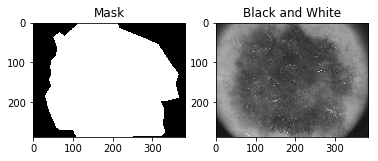

In [126]:
f, axarr = plt.subplots(1,2)
axarr[0].imshow(y_test[12,:,:,0])
axarr[0].set_title('Mask')
axarr[1].imshow(X_test_bw[12])
axarr[1].set_title('Black and White')
plt.gray()

In [127]:
pickle.dump(X_train_bw, open("./Segmentation2/train_data", "wb" ))
pickle.dump(y_train, open("./Segmentation2/train_labels", "wb" ))

pickle.dump(X_test_bw, open("./Segmentation2/test_data", "wb" ))
pickle.dump(y_test, open("./Segmentation2/test_labels", "wb" ))

In [3]:
X_train =  pickle.load(open("./Segmentation2/train_data", "rb" ))
y_train = pickle.load( open("./Segmentation2/train_labels", "rb" ))

X_test = pickle.load( open("./Segmentation2/test_data", "rb" ))
y_test = pickle.load( open("./Segmentation2/test_labels", "rb" ))

In [128]:
img_rows = 288
img_cols = 384

In [129]:
def dice(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)

    return (2. * intersection + 1) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1)

def dice_loss(y_true,y_pred):
    return -K.log(dice(y_true, y_pred))*10


In [130]:
def unet():
    
    inputs = Input((img_rows, img_cols, 1))


    conv2 = Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
    conv2 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(32, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(16, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv8)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv8)

    model = Model(inputs=[inputs], outputs=[conv10])

    
    
    model.compile(optimizer=Adam(lr=1e-5), loss=dice_loss, metrics=[dice])

    return model

In [131]:
model = unet()
print (model.output_shape)
print (model.input_shape)

(None, 288, 384, 1)
(None, 288, 384, 1)


In [191]:
weights_to_load = './Segmentation2/19__epoch_weights.h5'
model.load_weights(weights_to_load)

In [138]:
X_train_bw = X_train_bw[..., np.newaxis]
X_test_bw = X_test_bw[..., np.newaxis]

In [182]:
epochs = 20;
for epoch in range(10,epochs):
    for i in range(1,120):
        model.train_on_batch(X_train_bw[i*10:(i+1)*10],y_train[i*10:(i+1)*10])
        print ('Done with ' + str(i) + ' batch, ' + str(epoch) + ' epoch..')
    model.save_weights('./Segmentation2/' + str(epoch) + '_epoch_weights.hdf5')
    print ('Saved: ' + './Segmentation2/' + str(epoch) + '_epoch_weights.hdf5\n')

Done with 1 batch, 10 epoch..
Done with 2 batch, 10 epoch..
Done with 3 batch, 10 epoch..
Done with 4 batch, 10 epoch..
Done with 5 batch, 10 epoch..
Done with 6 batch, 10 epoch..
Done with 7 batch, 10 epoch..
Done with 8 batch, 10 epoch..
Done with 9 batch, 10 epoch..
Done with 10 batch, 10 epoch..
Done with 11 batch, 10 epoch..
Done with 12 batch, 10 epoch..
Done with 13 batch, 10 epoch..
Done with 14 batch, 10 epoch..
Done with 15 batch, 10 epoch..
Done with 16 batch, 10 epoch..
Done with 17 batch, 10 epoch..
Done with 18 batch, 10 epoch..
Done with 19 batch, 10 epoch..
Done with 20 batch, 10 epoch..
Done with 21 batch, 10 epoch..
Done with 22 batch, 10 epoch..
Done with 23 batch, 10 epoch..
Done with 24 batch, 10 epoch..
Done with 25 batch, 10 epoch..
Done with 26 batch, 10 epoch..
Done with 27 batch, 10 epoch..
Done with 28 batch, 10 epoch..
Done with 29 batch, 10 epoch..
Done with 30 batch, 10 epoch..
Done with 31 batch, 10 epoch..
Done with 32 batch, 10 epoch..
Done with 33 batc

Done with 24 batch, 12 epoch..
Done with 25 batch, 12 epoch..
Done with 26 batch, 12 epoch..
Done with 27 batch, 12 epoch..
Done with 28 batch, 12 epoch..
Done with 29 batch, 12 epoch..
Done with 30 batch, 12 epoch..
Done with 31 batch, 12 epoch..
Done with 32 batch, 12 epoch..
Done with 33 batch, 12 epoch..
Done with 34 batch, 12 epoch..
Done with 35 batch, 12 epoch..
Done with 36 batch, 12 epoch..
Done with 37 batch, 12 epoch..
Done with 38 batch, 12 epoch..
Done with 39 batch, 12 epoch..
Done with 40 batch, 12 epoch..
Done with 41 batch, 12 epoch..
Done with 42 batch, 12 epoch..
Done with 43 batch, 12 epoch..
Done with 44 batch, 12 epoch..
Done with 45 batch, 12 epoch..
Done with 46 batch, 12 epoch..
Done with 47 batch, 12 epoch..
Done with 48 batch, 12 epoch..
Done with 49 batch, 12 epoch..
Done with 50 batch, 12 epoch..
Done with 51 batch, 12 epoch..
Done with 52 batch, 12 epoch..
Done with 53 batch, 12 epoch..
Done with 54 batch, 12 epoch..
Done with 55 batch, 12 epoch..
Done wit

Done with 47 batch, 14 epoch..
Done with 48 batch, 14 epoch..
Done with 49 batch, 14 epoch..
Done with 50 batch, 14 epoch..
Done with 51 batch, 14 epoch..
Done with 52 batch, 14 epoch..
Done with 53 batch, 14 epoch..
Done with 54 batch, 14 epoch..
Done with 55 batch, 14 epoch..
Done with 56 batch, 14 epoch..
Done with 57 batch, 14 epoch..
Done with 58 batch, 14 epoch..
Done with 59 batch, 14 epoch..
Done with 60 batch, 14 epoch..
Done with 61 batch, 14 epoch..
Done with 62 batch, 14 epoch..
Done with 63 batch, 14 epoch..
Done with 64 batch, 14 epoch..
Done with 65 batch, 14 epoch..
Done with 66 batch, 14 epoch..
Done with 67 batch, 14 epoch..
Done with 68 batch, 14 epoch..
Done with 69 batch, 14 epoch..
Done with 70 batch, 14 epoch..
Done with 71 batch, 14 epoch..
Done with 72 batch, 14 epoch..
Done with 73 batch, 14 epoch..
Done with 74 batch, 14 epoch..
Done with 75 batch, 14 epoch..
Done with 76 batch, 14 epoch..
Done with 77 batch, 14 epoch..
Done with 78 batch, 14 epoch..
Done wit

Done with 70 batch, 16 epoch..
Done with 71 batch, 16 epoch..
Done with 72 batch, 16 epoch..
Done with 73 batch, 16 epoch..
Done with 74 batch, 16 epoch..
Done with 75 batch, 16 epoch..
Done with 76 batch, 16 epoch..
Done with 77 batch, 16 epoch..
Done with 78 batch, 16 epoch..
Done with 79 batch, 16 epoch..
Done with 80 batch, 16 epoch..
Done with 81 batch, 16 epoch..
Done with 82 batch, 16 epoch..
Done with 83 batch, 16 epoch..
Done with 84 batch, 16 epoch..
Done with 85 batch, 16 epoch..
Done with 86 batch, 16 epoch..
Done with 87 batch, 16 epoch..
Done with 88 batch, 16 epoch..
Done with 89 batch, 16 epoch..
Done with 90 batch, 16 epoch..
Done with 91 batch, 16 epoch..
Done with 92 batch, 16 epoch..
Done with 93 batch, 16 epoch..
Done with 94 batch, 16 epoch..
Done with 95 batch, 16 epoch..
Done with 96 batch, 16 epoch..
Done with 97 batch, 16 epoch..
Done with 98 batch, 16 epoch..
Done with 99 batch, 16 epoch..
Done with 100 batch, 16 epoch..
Done with 101 batch, 16 epoch..
Done w

Done with 93 batch, 18 epoch..
Done with 94 batch, 18 epoch..
Done with 95 batch, 18 epoch..
Done with 96 batch, 18 epoch..
Done with 97 batch, 18 epoch..
Done with 98 batch, 18 epoch..
Done with 99 batch, 18 epoch..
Done with 100 batch, 18 epoch..
Done with 101 batch, 18 epoch..
Done with 102 batch, 18 epoch..
Done with 103 batch, 18 epoch..
Done with 104 batch, 18 epoch..
Done with 105 batch, 18 epoch..
Done with 106 batch, 18 epoch..
Done with 107 batch, 18 epoch..
Done with 108 batch, 18 epoch..
Done with 109 batch, 18 epoch..
Done with 110 batch, 18 epoch..
Done with 111 batch, 18 epoch..
Done with 112 batch, 18 epoch..
Done with 113 batch, 18 epoch..
Done with 114 batch, 18 epoch..
Done with 115 batch, 18 epoch..
Done with 116 batch, 18 epoch..
Done with 117 batch, 18 epoch..
Done with 118 batch, 18 epoch..
Done with 119 batch, 18 epoch..
Saved: ./Segmentation2/18_epoch_weights.hdf5

Done with 1 batch, 19 epoch..
Done with 2 batch, 19 epoch..
Done with 3 batch, 19 epoch..
Done wi

In [192]:
print (model.metrics_names)
score = model.evaluate(X_test_bw, y_test, verbose=1)
print (score)

['loss', 'dice']
800/800 [==============================] - 497s 621ms/step
[6.7722100448608398, 0.51260903239250188]


In [209]:
print ('Dice Loss: %f\nDice Coefficient: %f'%(score[0],score[1]*100.0) + '%')

Dice Loss: 6.772210
Dice Coefficient: 51.260903%


In [196]:
preds = model.predict(X_test_bw[0:100])

In [198]:
displ = [7, 11, 13, 15, 17, 19, 20, 29, 32, 56]

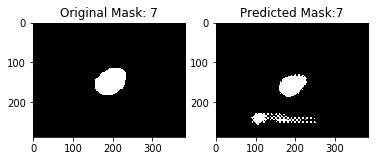

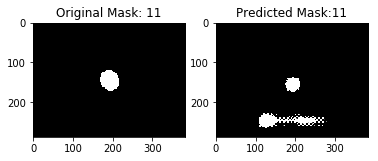

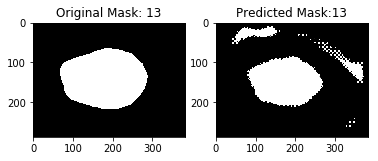

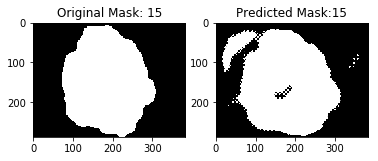

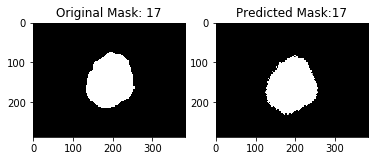

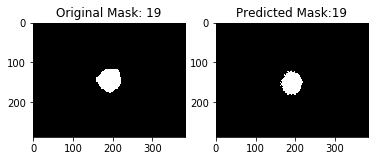

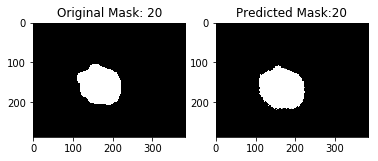

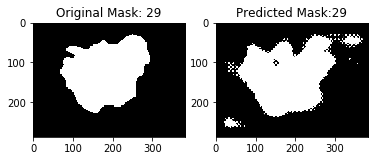

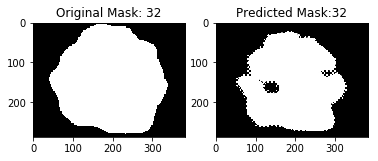

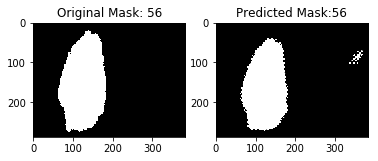

In [199]:
for i in displ:
    f, ax = plt.subplots(1,2)
    ax[0].imshow(y_test[i,:,:,0])
    ax[0].set_title('Original Mask: ' + str(i))
    ax[1].imshow((255*preds[i,:,:,0]).astype('uint8'))
    ax[1].set_title('Predicted Mask:' + str(i))
    plt.gray()